### Block 0: Install Dependencies
*Installs the essential `torch-geometric` library required for graph neural networks using pip.*

In [ ]:
! pip install torch-geometric -q

### Block 1: Setup & Configuration
*Imports all necessary libraries (`pandas`, `numpy`, `torch`, `torch_geometric`, `sklearn`, etc.). Sets up data paths for Kaggle, defines crucial model hyperparameters (`HIDDEN_CHANNELS`, `NUM_HGT_LAYERS`, `LEARNING_RATE`, `EPOCHS`, etc.), and configures the execution `device` (detecting and selecting GPU or defaulting to CPU).*

In [ ]:
# Block 1: Import Libraries and Setup Environment 
print("Block 1: Importing Libraries and Setting Up Environment...")

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, Linear
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm # Use notebook version for Kaggle
import warnings
import os
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='torch_geometric.utils.subgraph')
warnings.filterwarnings("ignore", category=FutureWarning)


# --- Configuration for Kaggle ---
DATA_PATH = '/kaggle/input/dat-graph'  

TRAIN_FILE = os.path.join(DATA_PATH, '/kaggle/input/created/train_set.csv')
VALID_FILE = os.path.join(DATA_PATH, '/kaggle/input/created/val_set.csv')
TEST_FILE = os.path.join(DATA_PATH, '/kaggle/input/created/test_set.csv')

# Model Hyperparameters (can be tuned)
HIDDEN_CHANNELS = 128 # Dimension of embeddings
OUT_CHANNELS = 64    # Dimension after HGT layers
NUM_HEADS = 4        # Number of attention heads in HGT
NUM_HGT_LAYERS = 2   # Number of HGT layers
LEARNING_RATE = 0.001
EPOCHS = 10 # Set to 10 epochs as requested
EMBEDDING_DIM = 64   # Initial dimension for node embeddings

# --- Device Setup ---
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} GPUs.")
    if num_gpus >= 2:
        device = torch.device('cuda:0') # Primary device for DataParallel
        gpu_ids = [0, 1]
        print(f"Using GPUs: {gpu_ids}")
    elif num_gpus == 1:
        device = torch.device('cuda:0')
        gpu_ids = [0]
        print("Using single GPU: cuda:0")
    else: 
         device = torch.device('cpu')
         gpu_ids = []
         print("Warning: CUDA available but no GPUs detected. Using CPU.")
else:
    device = torch.device('cpu')
    gpu_ids = []
    print("CUDA not available. Using CPU.")

print("-" * 30)
print(f"Primary Device: {device}")
print(f"GPU IDs for DataParallel: {gpu_ids}")
print("Block 1 execution finished.")
print("-" * 50)

Block 1: Importing Libraries and Setting Up Environment...
Found 2 GPUs.
Using GPUs: [0, 1]
------------------------------
Primary Device: cuda:0
GPU IDs for DataParallel: [0, 1]
Block 1 execution finished.
--------------------------------------------------


### Block 2: Load Datasets
*Reads the training (`train_set.csv`), validation (`val_set.csv`), and test (`test_set.csv`) network flow datasets from the specified `DATA_PATH` into pandas DataFrames. Displays basic info and shapes.*

In [ ]:
# Block 2: Load Data 
print("Block 2: Loading Data...")

try:
    df_train = pd.read_csv(TRAIN_FILE)
    df_valid = pd.read_csv(VALID_FILE)
    df_test = pd.read_csv(TEST_FILE)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure train.csv, valid.csv, and test.csv are in the correct directory.")
    # You might want to stop execution here if data isn't found
    raise e # Re-raise the exception to stop the notebook

print(f"Train data shape: {df_train.shape}")
print(f"Validation data shape: {df_valid.shape}")
print(f"Test data shape: {df_test.shape}")

# Display basic info for one dataframe
print("\nTrain Data Head:")
print(df_train.head())
print("\nTrain Data Info:")
df_train.info()


# Store original shapes for later verification if needed
original_shapes = {
    'train': df_train.shape,
    'valid': df_valid.shape,
    'test': df_test.shape
}

print("\nBlock 2 execution finished.")
print("-" * 50)

Block 2: Loading Data...


<ipython-input-15-4ca0bc12aab7>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(TRAIN_FILE)
<ipython-input-15-4ca0bc12aab7>:6: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_valid = pd.read_csv(VALID_FILE)
<ipython-input-15-4ca0bc12aab7>:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(TEST_FILE)


Train data shape: (160000, 49)
Validation data shape: (40000, 49)
Test data shape: (40000, 49)

Train Data Head:
        srcip  sport          dstip dsport proto state       dur  sbytes  \
0  59.166.0.7  47627  149.171.126.6  51280   tcp   FIN  0.012977    2126   
1  59.166.0.6  55495  149.171.126.1     80   tcp   FIN  0.024039    1058   
2  59.166.0.9  15824  149.171.126.7    111   udp   CON  0.037072     568   
3  59.166.0.3  15235  149.171.126.0     53   udp   CON  0.001055     146   
4  59.166.0.9  21468  149.171.126.7     53   udp   CON  0.001034     146   

   dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_srv_dst ct_dst_ltm  \
0   12514    31  ...           0           8           7          2   
1     822    31  ...           0           1           2          3   
2     304    31  ...           0           7           4          2   
3     178    31  ...           0           4           4          2   
4     178    31  ...           0           4           2          2   

   

### Block 3: Preprocessing (Categorical & Special Values)
*Handles data cleaning tasks:
    * Replaces special values like '-' in the `service` column.
    * Fills missing `attack_cat` values with 'Normal'.
    * Encodes categorical text features (`proto`, `service`, `state`) into numerical representations using `sklearn.preprocessing.LabelEncoder` for model consumption.*

In [ ]:
# Block 3: Preprocessing - Categorical Features and Special Values 
print("Block 3: Preprocessing Categorical Features and Special Values...")

# Identify categorical and numerical columns
# Include 'attack_cat' temporarily for cleaning, but don't encode it as a feature for binary task
categorical_cols_to_encode = ['proto', 'service', 'state']
all_cols = df_train.columns.tolist()
numerical_cols = [col for col in all_cols if df_train[col].dtype in ['int64', 'float64'] and col not in ['Label', 'attack_cat'] + categorical_cols_to_encode]
# Keep track of columns used as edge features later
edge_feature_cols = numerical_cols + ['proto_encoded', 'service_encoded', 'state_encoded'] # Will add encoded ones

print(f"Identified Categorical Columns to Encode: {categorical_cols_to_encode}")
print(f"Identified Numerical Columns (potential edge features): {numerical_cols}")

# --- Handle '-' in 'service' ---
# Treat '-' as a separate category 'none' or 'unknown'
for df in [df_train, df_valid, df_test]:
    df['service'] = df['service'].replace('-', 'unknown')
print("Replaced '-' in 'service' column with 'unknown'.")

# --- Handle blank/NaN in 'attack_cat' ---
# Replace NaN or empty strings with 'Normal'
for df in [df_train, df_valid, df_test]:
    # Fill NaN first, then potentially empty strings if NaNs weren't the only issue
    df['attack_cat'] = df['attack_cat'].fillna('Normal')
    df['attack_cat'] = df['attack_cat'].replace('', 'Normal')
    df['attack_cat'] = df['attack_cat'].replace(' ', 'Normal') # Handle potential space
print("Filled blank/NaN values in 'attack_cat' with 'Normal'.")
# Verify the change (optional)
print("Value counts for 'attack_cat' in training data after cleaning:")
print(df_train['attack_cat'].value_counts().head())


# --- Check for other NaNs (optional but good practice) ---
print("\nChecking for NaN values in other columns:")
print("Train NaNs:\n", df_train.isnull().sum().loc[lambda x: x > 0])
print("Valid NaNs:\n", df_valid.isnull().sum().loc[lambda x: x > 0])
print("Test NaNs:\n", df_test.isnull().sum().loc[lambda x: x > 0])
# If NaNs are found in numerical columns, imputation (e.g., with mean/median) would be needed here.
# Example: df_train[col].fillna(df_train[col].median(), inplace=True)

# --- Encode Categorical Features (proto, service, state) ---
# Use LabelEncoder. Fit *only* on training data unique values or combined data for consistency.
combined_categories = {
    col: pd.concat([df_train[col], df_valid[col], df_test[col]], axis=0).astype(str).unique()
    for col in categorical_cols_to_encode
}

encoders = {}
for col in categorical_cols_to_encode:
    print(f"Encoding '{col}'...")
    le = LabelEncoder()
    # Fit on all possible categories found across datasets
    le.fit(combined_categories[col])
    # Transform each dataset
    df_train[f'{col}_encoded'] = le.transform(df_train[col].astype(str))
    df_valid[f'{col}_encoded'] = le.transform(df_valid[col].astype(str))
    df_test[f'{col}_encoded'] = le.transform(df_test[col].astype(str))
    encoders[col] = le # Store encoder if needed later

# We don't encode 'attack_cat' as a feature for the binary intrusion *detection* task (Label 0/1)
# It's meta-information.

print("\nEncoded categorical columns added:")
print(df_train[['proto', 'proto_encoded', 'service', 'service_encoded', 'state', 'state_encoded']].head())

print("\nBlock 3 execution finished.")
print("-" * 50)

Block 3: Preprocessing Categorical Features and Special Values...
Identified Categorical Columns to Encode: ['proto', 'service', 'state']
Identified Numerical Columns (potential edge features): ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
Replaced '-' in 'service' column with 'unknown'.
Filled blank/NaN values in 'attack_cat' with 'Normal'.
Value counts for 'attack_cat' in training data after cleaning:
attack_cat
Normal            154922
Generic             1737
Exploits            1194
 Fuzzers            1145
Reconnaissance       416
Name: count, dtype: int64

Checkin

### Block 4: Preprocessing (Numerical Features)
*Handles potential infinity values (e.g., in `Sload`, `Dload`). Normalizes the range of numerical features using `sklearn.preprocessing.StandardScaler` (fitted *only* on training data to prevent data leakage) and defines the final set of features for graph edges.*


In [ ]:
# Block 4: Preprocessing - Numerical Features 
print("Block 4: Preprocessing Numerical Features...")

# --- Normalize Numerical Features ---
# Use StandardScaler. Fit *only* on training data.
scaler = StandardScaler()

print(f"Scaling numerical columns: {numerical_cols}")

# Handle potential infinity values before scaling (e.g., from division by zero if dur=0)
# A common case is Sload/Dload when dur=0. Let's replace inf with 0 for simplicity here.
for df in [df_train, df_valid, df_test]:
    for col in ['Sload', 'Dload']: # Add other columns if they can produce inf
        df[col] = df[col].replace([np.inf, -np.inf], 0)

# Check if any NaNs were introduced or need handling before scaling
# Fit scaler on training data
scaler.fit(df_train[numerical_cols])

# Apply scaler to all datasets
df_train[numerical_cols] = scaler.transform(df_train[numerical_cols])
df_valid[numerical_cols] = scaler.transform(df_valid[numerical_cols])
df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])

print("Numerical features scaled using StandardScaler (fitted on train data).")
print("\nScaled Train Data Head (Numerical Columns):")
print(df_train[numerical_cols].head())

# Update the list of columns to be used as edge features
edge_feature_cols_final = numerical_cols + ['proto_encoded', 'service_encoded', 'state_encoded']
print(f"\nFinal columns selected for IP-IP edge features: {edge_feature_cols_final}")
num_edge_features = len(edge_feature_cols_final)
print(f"Number of edge features: {num_edge_features}")


print("\nBlock 4 execution finished.")
print("-" * 50)

Block 4: Preprocessing Numerical Features...
Scaling numerical columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
Numerical features scaled using StandardScaler (fitted on train data).

Scaled Train Data Head (Numerical Columns):
        dur    sbytes    dbytes      sttl      dttl     sloss     dloss  \
0 -0.210452 -0.064835 -0.193864 -0.187202 -0.097383  0.036675 -0.175765   
1 -0.207426 -0.088560 -0.257106 -0.187202 -0.097383 -0.228102 -0.300416   
2 -0.203861 -0.099445 -0.259908 -0.187202 -0.097383 -0.334013 -0.331579   
3 -0.213714 -0.108820 -0.260590 -0.187202 -

### Block 5: Node & Edge Definition & Mapping
*Defines the structure of the heterogeneous graph:
    * **Node Types:** `ip`, `port`, `proto`.
    * **Node Mappings:** Extracts all unique IPs, ports, and protocols across datasets and creates dictionaries mapping them to unique integer IDs.
    * **Edge Types:** Defines the relationships between nodes, such as `('ip', 'flows_to', 'ip')`, `('ip', 'uses_port', 'port')`, and their inverses.*

In [ ]:
# Block 5: Node and Edge Definition & Mapping 
print("Block 5: Defining Node Types and Creating Mappings...")

# --- Define Node Types ---
node_types = ['ip', 'port', 'proto']
print(f"Defined node types: {node_types}")

# --- Extract Unique Nodes and Create Mappings ---
# Combine dataframes temporarily to get all unique entities across splits
df_combined = pd.concat([df_train, df_valid, df_test], ignore_index=True)

unique_ips = pd.concat([df_combined['srcip'], df_combined['dstip']]).astype(str).unique()
unique_ports = pd.concat([df_combined['sport'], df_combined['dsport']]).astype(str).unique()
# Ensure ports that might be non-numeric are handled (though unlikely in this dataset)
# unique_ports = [p for p in unique_ports if str(p).isdigit()] # Filter if needed
unique_protocols = df_combined['proto'].astype(str).unique() # Use original proto names

# Create mappings from entity name to a unique integer ID for each type
ip_map = {ip: i for i, ip in enumerate(unique_ips)}
port_map = {port: i for i, port in enumerate(unique_ports)}
proto_map = {proto: i for i, proto in enumerate(unique_protocols)}

num_ip_nodes = len(unique_ips)
num_port_nodes = len(unique_ports)
num_proto_nodes = len(unique_protocols)

print(f"Number of unique IP nodes: {num_ip_nodes}")
print(f"Number of unique Port nodes: {num_port_nodes}")
print(f"Number of unique Protocol nodes: {num_proto_nodes}")

# Mappings created (examples):
print("\nExample IP mapping:", list(ip_map.items())[:5])
print("Example Port mapping:", list(port_map.items())[:5])
print("Example Proto mapping:", list(proto_map.items())[:5])

# --- Define Edge Types ---
# ('source_node_type', 'relation_type', 'destination_node_type')
edge_types = [
    ('ip', 'flows_to', 'ip'),
    ('ip', 'uses_port', 'port'),
    ('port', 'used_by_ip', 'ip'), # Inverse relation for message passing
    ('port', 'uses_proto', 'proto'),
    ('proto', 'used_by_port', 'port') # Inverse relation
]
print(f"\nDefined edge types: {edge_types}")


print("\nBlock 5 execution finished.")
print("-" * 50)

Block 5: Defining Node Types and Creating Mappings...
Defined node types: ['ip', 'port', 'proto']
Number of unique IP nodes: 44
Number of unique Port nodes: 63902
Number of unique Protocol nodes: 134

Example IP mapping: [('59.166.0.7', 0), ('59.166.0.6', 1), ('59.166.0.9', 2), ('59.166.0.3', 3), ('59.166.0.1', 4)]
Example Port mapping: [('47627', 0), ('55495', 1), ('15824', 2), ('15235', 3), ('21468', 4)]
Example Proto mapping: [('tcp', 0), ('udp', 1), ('arp', 2), ('sps', 3), ('micp', 4)]

Defined edge types: [('ip', 'flows_to', 'ip'), ('ip', 'uses_port', 'port'), ('port', 'used_by_ip', 'ip'), ('port', 'uses_proto', 'proto'), ('proto', 'used_by_port', 'port')]

Block 5 execution finished.
--------------------------------------------------


### Block 6: Graph Construction Function
*Defines the core `create_hetero_data` function. This function converts a pandas DataFrame into a `torch_geometric.data.HeteroData` object by:
    * Initializing node features (embeddings).
    * Creating edge index tensors based on the node mappings for all defined edge types.
    * Assigning the preprocessed flow features as attributes (`edge_attr`) to the `('ip', 'flows_to', 'ip')` edges.
    * Assigning the binary labels (0/1) as `edge_label` to the `('ip', 'flows_to', 'ip')` edges.*


In [ ]:
# Block 6: Graph Construction Function 
print("Block 6: Defining Graph Construction Function...")

def create_hetero_data(df, ip_map, port_map, proto_map, edge_feature_cols, node_embedding_dim):
    """
    Constructs a PyTorch Geometric HeteroData object from the dataframe.
    """
    data = HeteroData()

    # --- Node Features ---
    # Initialize node features randomly (or use ones/zeros as placeholders)
    # More sophisticated features could be aggregated, but random embeddings are common.
    data['ip'].x = torch.randn(len(ip_map), node_embedding_dim)
    data['port'].x = torch.randn(len(port_map), node_embedding_dim)
    # For protocols, we could use one-hot or random embeddings. Let's use random.
    data['proto'].x = torch.randn(len(proto_map), node_embedding_dim)

    # --- Map IDs ---
    src_ip_ids = torch.tensor([ip_map[ip] for ip in df['srcip'].astype(str)], dtype=torch.long)
    dst_ip_ids = torch.tensor([ip_map[ip] for ip in df['dstip'].astype(str)], dtype=torch.long)
    src_port_ids = torch.tensor([port_map[port] for port in df['sport'].astype(str)], dtype=torch.long)
    dst_port_ids = torch.tensor([port_map[port] for port in df['dsport'].astype(str)], dtype=torch.long)
    proto_ids_mapped = torch.tensor([proto_map[p] for p in df['proto'].astype(str)], dtype=torch.long) # Map original proto str

    # --- Edge Index Tensors ---
    # ('ip', 'flows_to', 'ip') - Represents the network flows
    data['ip', 'flows_to', 'ip'].edge_index = torch.stack([src_ip_ids, dst_ip_ids], dim=0)

    # ('ip', 'uses_port', 'port') & ('port', 'used_by_ip', 'ip')
    # Combine src and dst ip-port pairs and remove duplicates
    ip_uses_port_edges = torch.unique(torch.stack([
        torch.cat([src_ip_ids, dst_ip_ids]),
        torch.cat([src_port_ids, dst_port_ids])
    ], dim=0), dim=1)
    data['ip', 'uses_port', 'port'].edge_index = ip_uses_port_edges
    data['port', 'used_by_ip', 'ip'].edge_index = torch.stack([ip_uses_port_edges[1], ip_uses_port_edges[0]], dim=0) # Inverse

    # ('port', 'uses_proto', 'proto') & ('proto', 'used_by_port', 'port')
    # Associate ports with the protocol used in the flow they participated in. Remove duplicates.
    port_uses_proto_edges = torch.unique(torch.stack([
        torch.cat([src_port_ids, dst_port_ids]), # All ports involved
        torch.cat([proto_ids_mapped, proto_ids_mapped]) # Corresponding protocols
    ], dim=0), dim=1)
    data['port', 'uses_proto', 'proto'].edge_index = port_uses_proto_edges
    data['proto', 'used_by_port', 'port'].edge_index = torch.stack([port_uses_proto_edges[1], port_uses_proto_edges[0]], dim=0) # Inverse

    # --- Edge Features & Labels ---
    # Features only for the 'flows_to' edges, representing the flow characteristics
    edge_features = torch.tensor(df[edge_feature_cols].values, dtype=torch.float)
    data['ip', 'flows_to', 'ip'].edge_attr = edge_features

    # Edge labels for the 'flows_to' edges (0 for normal, 1 for intrusion)
    edge_labels = torch.tensor(df['Label'].values, dtype=torch.long)
    data['ip', 'flows_to', 'ip'].edge_label = edge_labels

    # --- Add Metadata ---
    # Store number of nodes of each type (needed for some operations)
    data['ip'].num_nodes = len(ip_map)
    data['port'].num_nodes = len(port_map)
    data['proto'].num_nodes = len(proto_map)

    # Add node type information explicitly if needed by model later
    data.node_types = list(data.x_dict.keys())
    data.edge_types = list(data.edge_index_dict.keys())

    return data

print("Graph construction function defined.")
print("\nBlock 6 execution finished.")
print("-" * 50)

Block 6: Defining Graph Construction Function...
Graph construction function defined.

Block 6 execution finished.
--------------------------------------------------


### Block 7: Create Graph Objects & Move to Device
*Calls the `create_hetero_data` function to generate the final `HeteroData` objects (`train_data`, `valid_data`, `test_data`) for each dataset split. Includes checks for integrity and **moves the graph data objects to the target `device` (GPU/CPU)** using `.to(device)`.*

In [ ]:
# Block 7: Create Graph Data Objects 
print("Block 7: Creating HeteroData Objects for Train, Valid, Test...")

# Create the graph objects using the function defined in Block 6
train_data = create_hetero_data(df_train, ip_map, port_map, proto_map, edge_feature_cols_final, EMBEDDING_DIM)
valid_data = create_hetero_data(df_valid, ip_map, port_map, proto_map, edge_feature_cols_final, EMBEDDING_DIM)
test_data = create_hetero_data(df_test, ip_map, port_map, proto_map, edge_feature_cols_final, EMBEDDING_DIM)

print("\nHeteroData objects created initially.")
# --- Optional Check after creation ---
if 'train_data' in locals() and isinstance(train_data, HeteroData) and 'ip' in train_data.node_types and hasattr(train_data['ip'], 'x'):
    print(f"Initial train_data['ip'].x tensor device: {train_data['ip'].x.device}") # Should be cpu
else:
    print("Warning: Could not verify initial tensor device.")

# --- Move data to device ---
print(f"\nAttempting to move data objects to target device: {device}...")
try:
    train_data = train_data.to(device)
    valid_data = valid_data.to(device)
    test_data = test_data.to(device)
    print(f"--- Check after .to({device}) call ---")
    # Check existence and type again after the move attempt
    if 'train_data' in locals() and isinstance(train_data, HeteroData):
         if 'ip' in train_data.node_types and hasattr(train_data['ip'], 'x'):
              tensor_device = train_data['ip'].x.device
              print(f"Post-move train_data['ip'].x tensor device: {tensor_device}") # Should now match device
              if tensor_device == device:
                   print("Device move appears successful for train_data based on 'ip'.x tensor.")
              else:
                   # This should ideally not happen now based on previous debug
                   print(f"ERROR: Device mismatch after move! train_data['ip'].x is on {tensor_device}, expected {device}")
         else:
              print("ERROR: train_data['ip'].x tensor not found after move attempt.")
    else:
         print("ERROR: train_data variable lost or changed type during/after .to(device) call.")
    # --- End Check ---
    print(f"\nData objects supposedly moved to primary device: {device}")

except Exception as e:
    print(f"ERROR moving data to device: {e}")
    print("Potentially insufficient GPU memory. Try reducing embedding/hidden dims or dataset size.")
    import traceback
    traceback.print_exc()
    train_data = None # Ensure train_data is invalid if move fails
    print("!!! train_data set to None due to error during device move !!!")
    raise e

print("\nBlock 7 execution finished.")
print("-" * 50)

Block 7: Creating HeteroData Objects for Train, Valid, Test...

HeteroData objects created initially.
Initial train_data['ip'].x tensor device: cpu

Attempting to move data objects to target device: cuda:0...
--- Check after .to(cuda:0) call ---
Post-move train_data['ip'].x tensor device: cuda:0
Device move appears successful for train_data based on 'ip'.x tensor.

Data objects supposedly moved to primary device: cuda:0

Block 7 execution finished.
--------------------------------------------------


### Block 8: Graph Visualization
*Selects a smaller subgraph from the training data for clarity. Converts it to a `NetworkX` graph object. Uses `matplotlib` to generate and display a plot of this subgraph, coloring nodes by type (`ip`, `port`, `proto`) and **coloring edges to distinguish normal (green) vs. intrusion (red) IP flows**, providing visual insight into the graph structure.*

Block 8: Visualizing a Subgraph of the Training Data...
Attempting to select up to 90 nodes for visualization (40 IP, 40 Port, 10 Proto).
Subgraph contains 90 nodes and 159539 edges (after filtering).
Converted subgraph to NetworkX graph with 90 nodes and 671 edges.
Mapping NetworkX nodes to types for coloring...
  Type: ip, Count: 40
  Type: port, Count: 40
  Type: proto, Count: 10
Nodes drawn.
Found 253 IP-IP edges with labels in the subgraph.
Categorizing edges for coloring...
Edge categories: Normal=224, Attack=29, Other=418
Edges drawn.


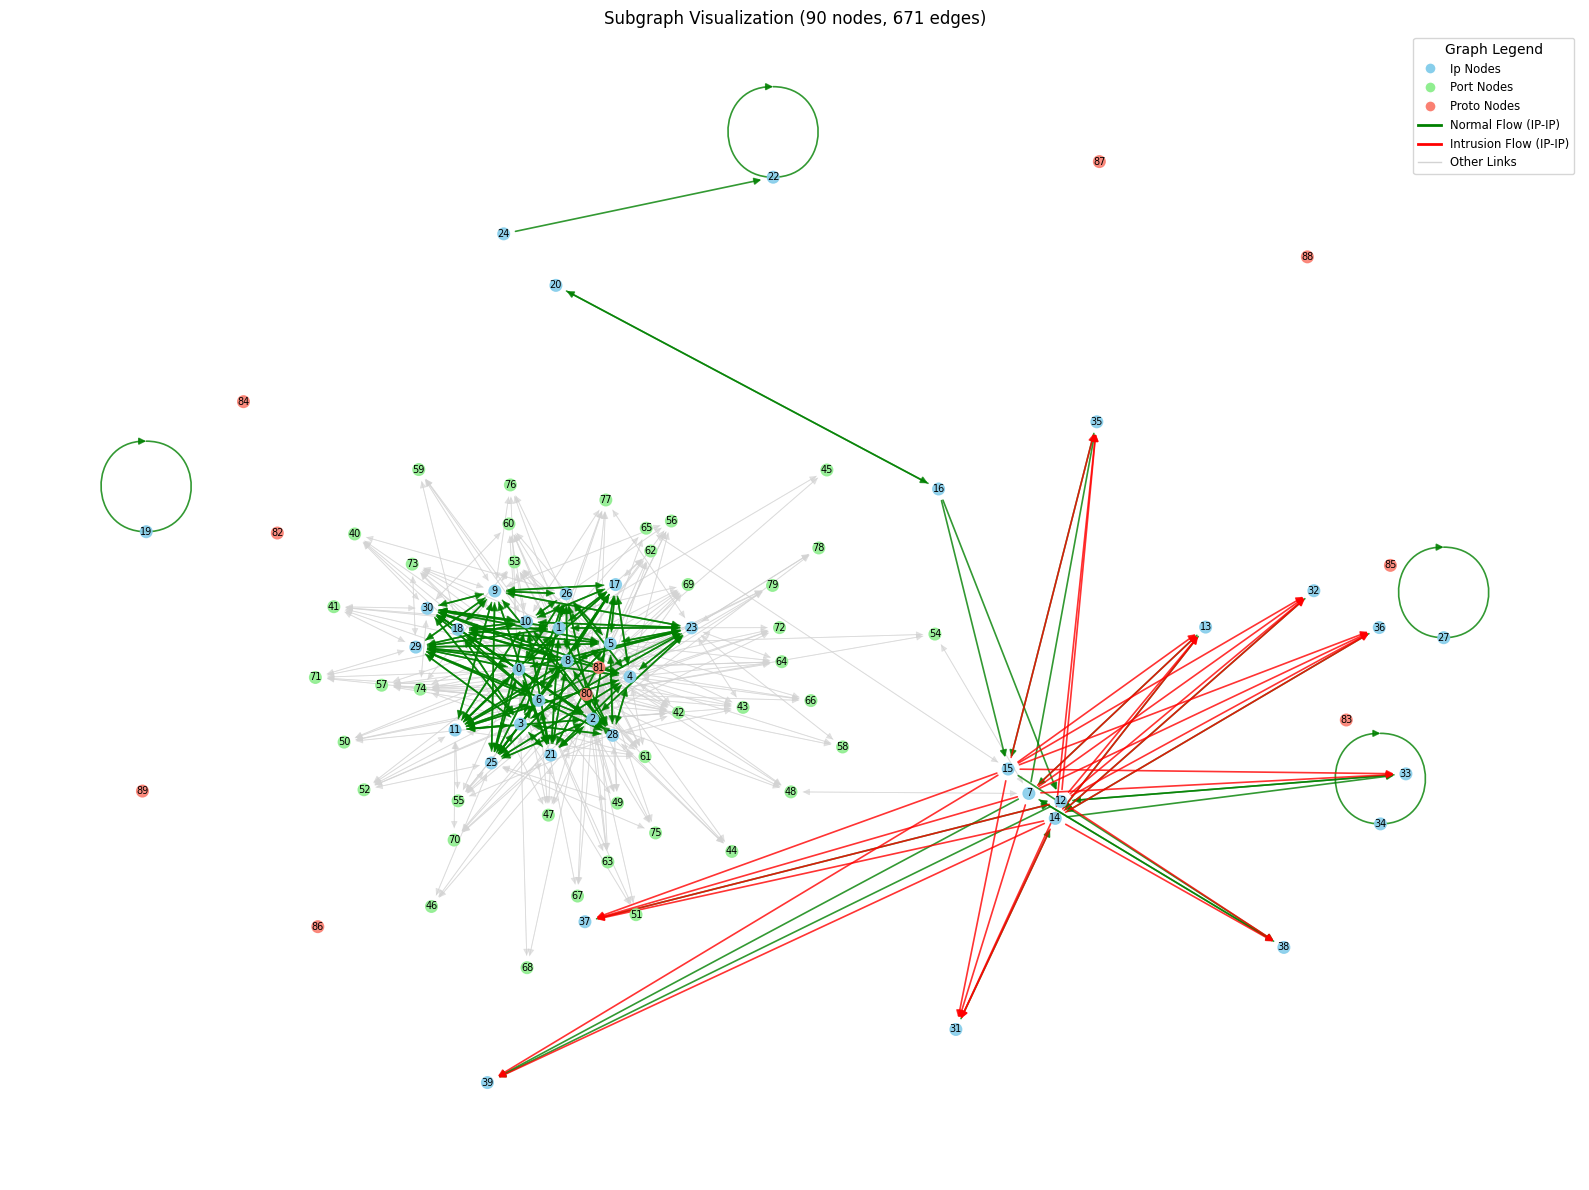


Block 8 execution finished.
--------------------------------------------------


In [ ]:
# Block 8: Graph Visualization (Subsample) 
print("Block 8: Visualizing a Subgraph of the Training Data...")

try:
    # --- Select a Subset for Visualization ---
    # Select the first K nodes of each type to control the total node count
    num_ip_vis = 40     # Target number of IP nodes
    num_port_vis = 40   # Target number of Port nodes
    num_proto_vis = 10  # Target number of Protocol nodes (usually fewer unique protocols)
    target_total_nodes = num_ip_vis + num_port_vis + num_proto_vis
    print(f"Attempting to select up to {target_total_nodes} nodes for visualization ({num_ip_vis} IP, {num_port_vis} Port, {num_proto_vis} Proto).")

    # Ensure data is on CPU for visualization tools like NetworkX
    # Use the original train_data which should be on the primary device, then move to cpu
    vis_train_data = train_data.cpu()

    # Create a dictionary mapping node type to the indices of the first K nodes
    node_dict_vis = {}
    node_dict_vis['ip'] = torch.arange(min(num_ip_vis, vis_train_data['ip'].num_nodes))
    node_dict_vis['port'] = torch.arange(min(num_port_vis, vis_train_data['port'].num_nodes))
    node_dict_vis['proto'] = torch.arange(min(num_proto_vis, vis_train_data['proto'].num_nodes))

    # Use PyG's subgraph utility. This keeps only the selected nodes
    # AND only the edges that exist BETWEEN these selected nodes in the original graph.
    subgraph_data = vis_train_data.subgraph(node_dict_vis)

    # Check actual number of nodes in the resulting subgraph (might be less than K if some nodes had no edges)
    actual_subgraph_nodes = sum(subgraph_data[nt].num_nodes for nt in subgraph_data.node_types)
    print(f"Subgraph contains {actual_subgraph_nodes} nodes and {subgraph_data.num_edges} edges (after filtering).")

    # --- Convert to NetworkX ---
    G_vis = None
    try:
        # Ensure features exist for conversion, even if dummy (needed by to_networkx)
        for node_type in subgraph_data.node_types:
             if subgraph_data[node_type].x is None:
                 num_nodes = subgraph_data[node_type].num_nodes
                 if num_nodes > 0:
                     subgraph_data[node_type].x = torch.zeros((num_nodes, 1)) # Add dummy feature

        # Convert the subgraph to NetworkX format (removed edge_types argument)
        # node_attrs and edge_attrs can be added if needed later, keeping it simple now.
        G_vis = to_networkx(subgraph_data, node_attrs=None, edge_attrs=None)
        print(f"Converted subgraph to NetworkX graph with {G_vis.number_of_nodes()} nodes and {G_vis.number_of_edges()} edges.")

    except Exception as e_nx:
        print(f"Error during to_networkx conversion: {e_nx}")
        G_vis = None # Ensure G_vis is None if conversion fails


    # --- Plotting (if conversion succeeded) ---
    if G_vis and G_vis.number_of_nodes() > 0:
        plt.figure(figsize=(16, 12)) # Slightly larger figure
        pos = nx.spring_layout(G_vis, k=0.5, iterations=50) # Adjust layout parameters if needed

        # --- Node Coloring ---
        # Map node IDs in NetworkX graph back to original node type and subgraph index
        # to_networkx typically creates nodes sequentially based on node_types order if not specified otherwise
        node_color_map = {'ip': 'skyblue', 'port': 'lightgreen', 'proto': 'salmon'}
        node_color_list = []
        # This mapping assumes NetworkX node IDs 0..N correspond sequentially to the nodes in subgraph_data
        # It iterates through node types found in the subgraph and assigns colors.
        current_node_idx = 0
        nx_node_to_subgraph_map = {} # Map nx node index -> (type, subgraph_type_index)
        subgraph_idx_to_type = {} # Map subgraph_type_index -> type (for edge checking)

        print("Mapping NetworkX nodes to types for coloring...")
        for node_type in subgraph_data.node_types: # Iterate in the order PyG likely uses
            num_nodes_of_type = subgraph_data[node_type].num_nodes
            print(f"  Type: {node_type}, Count: {num_nodes_of_type}")
            color = node_color_map.get(node_type, 'gray')
            for i in range(num_nodes_of_type):
                nx_node_id = current_node_idx + i
                if nx_node_id < G_vis.number_of_nodes(): # Safety check
                    node_color_list.append(color)
                    nx_node_to_subgraph_map[nx_node_id] = (node_type, i)
                    subgraph_idx_to_type[(node_type, i)] = node_type # Store type by subgraph index tuple
                else:
                     print(f"Warning: NetworkX node ID {nx_node_id} out of bounds ({G_vis.number_of_nodes()}).")
            current_node_idx += num_nodes_of_type

        if len(node_color_list) != G_vis.number_of_nodes():
            print(f"Warning: Node color list length ({len(node_color_list)}) mismatch with NetworkX nodes ({G_vis.number_of_nodes()}). Check node ordering assumptions. Using default color.")
            # Fallback: Generate default colors if list is wrong size
            node_color_list = ['gray'] * G_vis.number_of_nodes()


        # Draw nodes first
        nx.draw_networkx_nodes(G_vis, pos, node_color=node_color_list, node_size=70, alpha=0.9)
        print("Nodes drawn.")

        # --- Edge Coloring ---
        edge_list_ip_normal = []
        edge_list_ip_attack = []
        edge_list_other = []

        # Get labels for the IP-IP edges that are present in the subgraph
        if ('ip', 'flows_to', 'ip') in subgraph_data.edge_types:
            ip_ip_edge_index_sub = subgraph_data['ip', 'flows_to', 'ip'].edge_index # Indices relative to subgraph IP nodes
            ip_ip_edge_labels_sub = subgraph_data['ip', 'flows_to', 'ip'].edge_label

            # Create a map for quick lookup: (src_sub_idx, dst_sub_idx) -> label
            ip_ip_label_map = {
                (ip_ip_edge_index_sub[0, i].item(), ip_ip_edge_index_sub[1, i].item()): ip_ip_edge_labels_sub[i].item()
                for i in range(ip_ip_edge_index_sub.shape[1])
            }
            print(f"Found {len(ip_ip_label_map)} IP-IP edges with labels in the subgraph.")
        else:
            ip_ip_label_map = {}
            print("No ('ip', 'flows_to', 'ip') edges found in the subgraph data.")


        print("Categorizing edges for coloring...")
        for u_nx, v_nx in G_vis.edges():
            # Get node types from our mapping based on NetworkX indices
            u_map_info = nx_node_to_subgraph_map.get(u_nx)
            v_map_info = nx_node_to_subgraph_map.get(v_nx)

            if u_map_info is None or v_map_info is None:
                edge_list_other.append((u_nx, v_nx)) # Should not happen if mapping is correct
                continue

            u_type, u_sub_idx = u_map_info
            v_type, v_sub_idx = v_map_info

            is_ip_ip = u_type == 'ip' and v_type == 'ip'

            if is_ip_ip:
                # Look up label using the subgraph indices for IP nodes
                label = ip_ip_label_map.get((u_sub_idx, v_sub_idx))
                # Check reverse direction just in case? (Usually not needed if PyG edge_index is consistent)
                # if label is None:
                #     label = ip_ip_label_map.get((v_sub_idx, u_sub_idx))

                if label == 1: # Intrusion
                    edge_list_ip_attack.append((u_nx, v_nx))
                elif label == 0: # Normal
                    edge_list_ip_normal.append((u_nx, v_nx))
                else: # IP-IP edge in G_vis but not in our label map (e.g., conversion inconsistency?)
                     edge_list_other.append((u_nx, v_nx))
            else: # Not an IP-IP edge
                edge_list_other.append((u_nx, v_nx))

        print(f"Edge categories: Normal={len(edge_list_ip_normal)}, Attack={len(edge_list_ip_attack)}, Other={len(edge_list_other)}")

        # Draw edges with different colors
        nx.draw_networkx_edges(G_vis, pos, edgelist=edge_list_other, edge_color='lightgray', width=0.6, alpha=0.6)
        nx.draw_networkx_edges(G_vis, pos, edgelist=edge_list_ip_normal, edge_color='green', width=1.2, alpha=0.8)
        nx.draw_networkx_edges(G_vis, pos, edgelist=edge_list_ip_attack, edge_color='red', width=1.2, alpha=0.8)
        print("Edges drawn.")

        # --- Labels and Legend ---
        # Add labels if graph isn't too dense
        if G_vis.number_of_nodes() < 150:
             nx.draw_networkx_labels(G_vis, pos, font_size=7)

        # Create legend handles
        node_legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{nt.capitalize()} Nodes',
                                        markersize=8, markerfacecolor=c)
                              for nt, c in node_color_map.items()]
        edge_legend_handles = [
            plt.Line2D([0], [0], color='green', lw=2, label='Normal Flow (IP-IP)'),
            plt.Line2D([0], [0], color='red', lw=2, label='Intrusion Flow (IP-IP)'),
            plt.Line2D([0], [0], color='lightgray', lw=1, label='Other Links')
        ]

        plt.legend(handles=node_legend_handles + edge_legend_handles, title="Graph Legend", loc='best', fontsize='small')
        plt.title(f'Subgraph Visualization ({G_vis.number_of_nodes()} nodes, {G_vis.number_of_edges()} edges)')
        plt.axis('off') # Hide axes
        plt.tight_layout()
        plt.show()

    elif G_vis is None:
        print("Skipping plot because graph conversion failed.")
    else: # G_vis exists but has 0 nodes
        print("Skipping plot because the subgraph is empty.")

except Exception as e:
    print(f"An unexpected error occurred during visualization: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback for debugging
    print("Skipping visualization block due to error.")

print("\nBlock 8 execution finished.")
print("-" * 50)

### Block 9: Define HGT Model Architecture
*Defines the Graph Neural Network model (`HGTEdgeClassifier`) using `torch_geometric.nn.HGTConv` (Heterogeneous Graph Transformer). This model takes the `HeteroData` as input, processes node and edge information through multiple layers and attention heads, and outputs classification logits for the `('ip', 'flows_to', 'ip')` edges. Instantiates the model and moves it to the target `device`.*

In [ ]:
# Block 9: Define HGT Model 
print("Block 9: Defining the HGT Model...")

class HGTEdgeClassifier(torch.nn.Module):
    # ... (Your HGTEdgeClassifier class definition remains unchanged) ...
    # Make sure the class definition is here
    def __init__(self, data, hidden_channels, out_channels, num_heads, num_layers, embedding_dim, num_edge_features):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.num_heads = num_heads

        self.node_types = data.node_types
        self.metadata = (data.node_types, data.edge_types)

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            # Ensure input dimension matches embedding_dim used in data creation
            self.lin_dict[node_type] = Linear(embedding_dim, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, self.metadata, num_heads)
            self.convs.append(conv)

        self.classifier = nn.Sequential(
            Linear(2 * hidden_channels + num_edge_features, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
            Linear(hidden_channels, 2) # Output size 2 for binary classification (logits)
        )

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # Apply initial linear transformation and activation
        for node_type, x in x_dict.items():
             # Check if linear layer exists for this node type
             if node_type in self.lin_dict:
                 x_dict[node_type] = self.lin_dict[node_type](x).relu_()
             # Else: Keep original features if no transformation defined (or handle error)

        # Pass through HGT layers
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        # --- Edge Prediction for ('ip', 'flows_to', 'ip') ---
        ip_edge_index = edge_index_dict[('ip', 'flows_to', 'ip')]
        src_ip_emb = x_dict['ip'][ip_edge_index[0]]
        dst_ip_emb = x_dict['ip'][ip_edge_index[1]]
        ip_edge_attr = edge_attr_dict[('ip', 'flows_to', 'ip')]

        # Concatenate source node embedding, destination node embedding, and edge features
        combined_features = torch.cat([src_ip_emb, dst_ip_emb, ip_edge_attr], dim=-1)

        # Pass through the classifier
        edge_logits = self.classifier(combined_features)

        return edge_logits


# Instantiate model
# Ensure train_data exists and is on the correct device (checked before Block 10 now)
model = HGTEdgeClassifier(
    data=train_data, # Pass train_data to get metadata
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=OUT_CHANNELS, # Note: out_channels isn't directly used in this classifier structure
    num_heads=NUM_HEADS,
    num_layers=NUM_HGT_LAYERS,
    embedding_dim=EMBEDDING_DIM, # Matches data creation
    num_edge_features=num_edge_features # Matches data creation
)

# Use the 'device' defined in Block 1
print(f"Using device defined in Block 1: {device}")

# Move ONLY the model to the device
model = model.to(device)

# Data should already be on the device from Block 7 - DO NOT move it again here.
print("Model moved to device.")
# print(f"Verifying train_data device (should match): {train_data['ip'].x.device}") # Optional verification

print(f"Model:\n{model}")
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print("\nBlock 9 execution finished.")
print("-" * 50)

Block 9: Defining the HGT Model...
Using device defined in Block 1: cuda:0
Model moved to device.
Model:
HGTEdgeClassifier(
  (lin_dict): ModuleDict(
    (ip): Linear(64, 128, bias=True)
    (port): Linear(64, 128, bias=True)
    (proto): Linear(64, 128, bias=True)
  )
  (convs): ModuleList(
    (0-1): 2 x HGTConv(-1, 128, heads=4)
  )
  (classifier): Sequential(
    (0): Linear(299, 128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(128, 2, bias=True)
  )
)
Total trainable parameters: 541872

Block 9 execution finished.
--------------------------------------------------


### Block 10: Training Setup (Loss, Optimizer, Metrics)
*Prepares the components needed for training:
    * **Class Weights:** Calculates weights inversely proportional to class frequencies in the training data to counteract class imbalance.
    * **Loss Function:** Initializes the `torch.nn.CrossEntropyLoss` criterion, passing the calculated `class_weights` to it (Weighted Cross-Entropy).
    * **Optimizer:** Initializes the `Adam` optimizer to update model parameters.
    * **Metrics Functions:** Defines helper functions (`calculate_metrics_from_labels`, `calculate_metrics_from_logits`) using `sklearn.metrics` to compute Accuracy, Precision, Recall, and F1-Score, particularly focusing on the 'intrusion' class.*

In [ ]:
# Block 10: Training Setup 
print("Block 10: Setting up Optimizer, Loss (Weighted), and Metrics...")

# --- Corrected Check for train_data and device ---
# Check 1: Does train_data exist and is it the right type?
if 'train_data' not in locals() or not isinstance(train_data, HeteroData):
     raise ValueError("Variable 'train_data' not found or is not a HeteroData object. Ensure Block 7 ran successfully and assigned train_data globally.")
# Check 2: Does the relevant data tensor exist within train_data?
elif 'ip' not in train_data.node_types or not hasattr(train_data['ip'], 'x'):
     raise ValueError("train_data exists, but train_data['ip'].x (node features) is missing. Check graph creation in Block 6/7.")
# Check 3: Is the tensor on the correct device?
elif train_data['ip'].x.device != device:
     tensor_device = train_data['ip'].x.device
     raise ValueError(f"Device mismatch: train_data['ip'].x is on {tensor_device}, but target device is {device}. Check the .to(device) call and output in Block 7. Ensure no cells between Block 7 and 10 modify train_data.")
else:
    # If all checks pass, proceed
    print(f"train_data found, seems valid, and train_data['ip'].x is on the correct device ({device}). Proceeding...")


# --- Calculate Class Weights for Weighted Loss ---
edge_labels_train = train_data['ip', 'flows_to', 'ip'].edge_label
# Count classes
count_class_0 = (edge_labels_train == 0).sum().item()
count_class_1 = (edge_labels_train == 1).sum().item()
total_samples = len(edge_labels_train)
print(f"Training samples: Total={total_samples}, Normal (0)={count_class_0}, Intrusion (1)={count_class_1}")

if count_class_0 > 0 and count_class_1 > 0:
    weight_class_0 = total_samples / (2 * count_class_0)
    weight_class_1 = total_samples / (2 * count_class_1)
    class_weights = torch.tensor([weight_class_0, weight_class_1], dtype=torch.float).to(device)
    print(f"Calculated Class Weights: {class_weights.cpu().numpy()}")
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    print(f"Using Weighted CrossEntropyLoss: {criterion}")
else:
    print("Warning: One class has zero samples in the training set. Using standard CrossEntropyLoss.")
    criterion = torch.nn.CrossEntropyLoss()
    print(f"Using Standard CrossEntropyLoss: {criterion}")

# --- Optimizer ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
print(f"Using Optimizer: Adam (LR={LEARNING_RATE})")

# --- Metrics Function (Accepts labels directly) ---
def calculate_metrics_from_labels(y_true_labels, y_pred_labels):
     # (Implementation from previous steps)
     y_true_labels = np.asarray(y_true_labels)
     y_pred_labels = np.asarray(y_pred_labels)
     accuracy = accuracy_score(y_true_labels, y_pred_labels)
     precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(
         y_true_labels, y_pred_labels, average='macro', zero_division=0)
     precision_i, recall_i, f1_i, _ = precision_recall_fscore_support(
         y_true_labels, y_pred_labels, labels=[1], average='binary', zero_division=0)
     return {'accuracy': accuracy, 'precision_macro': precision_m, 'recall_macro': recall_m, 'f1_macro': f1_m,
             'precision_intru': precision_i, 'recall_intru': recall_i, 'f1_intru': f1_i}

def calculate_metrics_from_logits(y_true, y_pred_logits):
    # (Implementation from previous steps)
    y_pred_labels = y_pred_logits.argmax(dim=-1).cpu().numpy()
    y_true_labels = y_true.cpu().numpy()
    return calculate_metrics_from_labels(y_true_labels, y_pred_labels)

print("Metrics calculation functions defined.")
print("\nBlock 10 execution finished.")
print("-" * 50)

Block 10: Setting up Optimizer, Loss (Weighted), and Metrics...
train_data found, seems valid, and train_data['ip'].x is on the correct device (cuda:0). Proceeding...
Training samples: Total=160000, Normal (0)=154922, Intrusion (1)=5078
Calculated Class Weights: [ 0.5163889 15.754234 ]
Using Weighted CrossEntropyLoss: CrossEntropyLoss()
Using Optimizer: Adam (LR=0.001)
Metrics calculation functions defined.

Block 10 execution finished.
--------------------------------------------------


### Block 11: Training & Validation Loop
*Executes the model training process over the specified number of `EPOCHS`:
    * **Training Step:** Processes `train_data`, calculates weighted loss, performs backpropagation, and updates model weights via the optimizer.
    * **Validation Step:** Evaluates the model's performance on `valid_data` using the defined metrics (without updating weights).
    * **Logging:** Prints and stores metrics (Loss, Accuracy, F1-Intrusion, Recall-Intrusion) for both training and validation sets for each epoch.*


In [ ]:
# Block 11: Training and Validation Loop 
print("Block 11: Starting Training and Validation Loop...")

history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1_intru': [],
    'val_f1_intru': [],
    'train_recall_intru': [],
    'val_recall_intru': []
}

epoch_iterator = tqdm(range(EPOCHS), desc="Epochs")

for epoch in epoch_iterator:
    # --- Training Phase ---
    model.train()
    optimizer.zero_grad()

    # Ensure data is on the correct device (redundant if done in Block 7, but safe)
    train_data = train_data.to(device)

    out_logits = model(train_data.x_dict, train_data.edge_index_dict, train_data.edge_attr_dict)
    target_labels = train_data['ip', 'flows_to', 'ip'].edge_label

    loss = criterion(out_logits, target_labels)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    with torch.no_grad():
        # Use the helper function that takes logits
        train_metrics = calculate_metrics_from_logits(target_labels.detach(), out_logits.detach())

    # --- Validation Phase ---
    model.eval()
    with torch.no_grad():
        # Ensure data is on the correct device
        valid_data = valid_data.to(device)

        val_logits = model(valid_data.x_dict, valid_data.edge_index_dict, valid_data.edge_attr_dict)
        val_target_labels = valid_data['ip', 'flows_to', 'ip'].edge_label

        val_loss = criterion(val_logits, val_target_labels).item()
        # Use the helper function that takes logits
        val_metrics = calculate_metrics_from_logits(val_target_labels, val_logits)

    # --- Store Metrics ---
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['train_f1_intru'].append(train_metrics['f1_intru'])
    history['val_f1_intru'].append(val_metrics['f1_intru'])
    history['train_recall_intru'].append(train_metrics['recall_intru'])
    history['val_recall_intru'].append(val_metrics['recall_intru'])

    # Log message remains the same as before
    log_msg = (
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}, F1(I): {train_metrics['f1_intru']:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, F1(I): {val_metrics['f1_intru']:.4f}, Recall(I): {val_metrics['recall_intru']:.4f}"
    )

    epoch_iterator.set_description(f"Epoch {epoch+1}")
    epoch_iterator.set_postfix_str(f"TrL={train_loss:.3f}, VAcc={val_metrics['accuracy']:.3f}, VF1(I)={val_metrics['f1_intru']:.3f}")

    print(log_msg)

epoch_iterator.close()
print("\nTraining and validation loop finished.")
print("\nBlock 11 execution finished.")
print("-" * 50)

Block 11: Starting Training and Validation Loop...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 1.0804, Acc: 0.6836, F1(I): 0.0631 | Val Loss: 0.6455, Acc: 0.9399, F1(I): 0.3295, Recall(I): 0.4654
Epoch 2/10 | Train Loss: 0.9927, Acc: 0.5376, F1(I): 0.0653 | Val Loss: 0.6400, Acc: 0.0767, F1(I): 0.0642, Recall(I): 0.9969
Epoch 3/10 | Train Loss: 0.9613, Acc: 0.4481, F1(I): 0.0689 | Val Loss: 0.6299, Acc: 0.0685, F1(I): 0.0637, Recall(I): 0.9984
Epoch 4/10 | Train Loss: 0.9168, Acc: 0.4308, F1(I): 0.0728 | Val Loss: 0.5900, Acc: 0.1099, F1(I): 0.0665, Recall(I): 0.9984
Epoch 5/10 | Train Loss: 0.8505, Acc: 0.4618, F1(I): 0.0776 | Val Loss: 0.5416, Acc: 0.5788, F1(I): 0.1308, Recall(I): 0.9984
Epoch 6/10 | Train Loss: 0.7924, Acc: 0.5185, F1(I): 0.0837 | Val Loss: 0.5032, Acc: 0.9567, F1(I): 0.5937, Recall(I): 0.9953
Epoch 7/10 | Train Loss: 0.7356, Acc: 0.5852, F1(I): 0.0920 | Val Loss: 0.4790, Acc: 0.9870, F1(I): 0.8278, Recall(I): 0.9843
Epoch 8/10 | Train Loss: 0.6927, Acc: 0.6524, F1(I): 0.1042 | Val Loss: 0.4618, Acc: 0.9879, F1(I): 0.8316, Recall(I):

### Block 12: Testing Phase & Threshold Adjustment
*Performs the final evaluation on the unseen `test_data`:
    * **Optimal Threshold Finding:** Runs the trained model on the `valid_data` to get probabilities. Iterates through different probability thresholds (e.g., 0.05 to 0.95) and selects the threshold that maximizes the F1-score for the intrusion class on the validation set.
    * **Test Evaluation:** Runs the model on `test_data`. Applies the **optimal threshold** found previously to the output probabilities to get final predictions.
    * **Metrics Calculation:** Calculates and prints the final test performance metrics using the threshold-adjusted predictions.*


Block 12: Starting Testing with Threshold Adjustment...

--- Finding Optimal Threshold on Validation Set ---
Best Threshold found on Validation Set: 0.4724 (yielding F1 Intrusion: 0.8430)


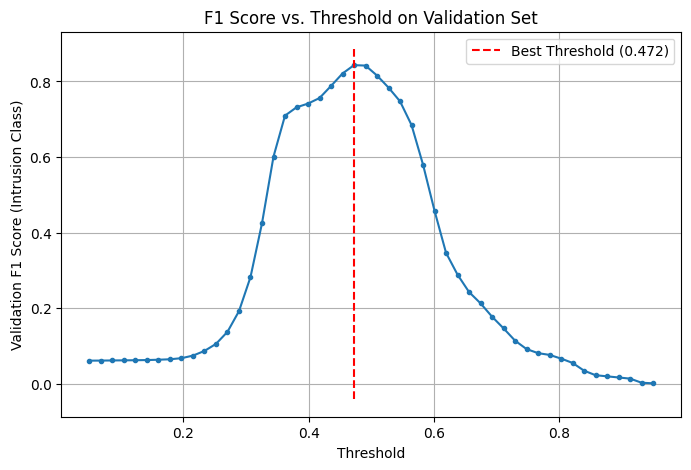


--- Evaluating on Test Set using Optimal Threshold ---

--- Final Test Results (with Threshold Adjustment) ---
Optimal Threshold Used: 0.4724
Test Loss (calculated before thresholding): 0.4199
--------------------
Test Accuracy: 0.9883
Test Precision (Macro): 0.8692
Test Recall (Macro): 0.9814
Test F1 (Macro): 0.9172
--------------------
Test Precision (Intrusion): 0.7392
Test Recall (Intrusion): 0.9740
Test F1 (Intrusion): 0.8405
---------------------------

Block 12 execution finished.
--------------------------------------------------


In [ ]:
# Block 12: Testing Phase 
print("Block 12: Starting Testing with Threshold Adjustment...")

model.eval()  # Set model to evaluation mode

# --- Step 1: Find Optimal Threshold on Validation Set ---
print("\n--- Finding Optimal Threshold on Validation Set ---")
best_threshold = 0.5 # Default
best_val_f1_intru = -1 # Initialize with invalid value

with torch.no_grad():
    # Ensure validation data is on device
    valid_data = valid_data.to(device)
    val_logits = model(valid_data.x_dict, valid_data.edge_index_dict, valid_data.edge_attr_dict)
    # Get probabilities for the positive class (intrusion=1)
    val_probs = F.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
    val_true_labels = valid_data['ip', 'flows_to', 'ip'].edge_label.cpu().numpy()

    # Iterate through potential thresholds
    thresholds = np.linspace(0.05, 0.95, 50) # Test 50 thresholds
    val_f1_scores = []
    for threshold in thresholds:
        # Apply threshold to get predicted labels
        val_pred_labels = (val_probs >= threshold).astype(int)
        # Calculate metrics using labels
        metrics = calculate_metrics_from_labels(val_true_labels, val_pred_labels)
        f1_intru = metrics['f1_intru']
        val_f1_scores.append(f1_intru)
        # print(f"Threshold: {threshold:.3f}, Val F1 (Intrusion): {f1_intru:.4f}") # Optional: print per threshold

        # Update best threshold if current F1 is better
        if f1_intru > best_val_f1_intru:
            best_val_f1_intru = f1_intru
            best_threshold = threshold

print(f"Best Threshold found on Validation Set: {best_threshold:.4f} (yielding F1 Intrusion: {best_val_f1_intru:.4f})")

# Plot Validation F1 vs Threshold (Optional)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, val_f1_scores, marker='.')
plt.xlabel("Threshold")
plt.ylabel("Validation F1 Score (Intrusion Class)")
plt.title("F1 Score vs. Threshold on Validation Set")
plt.vlines(best_threshold, plt.ylim()[0], plt.ylim()[1], color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.3f})')
plt.legend()
plt.grid(True)
plt.show()


# --- Step 2: Evaluate on Test Set using the Optimal Threshold ---
print("\n--- Evaluating on Test Set using Optimal Threshold ---")
all_test_preds_final = []
all_test_labels_final = []
test_metrics_final = {}

with torch.no_grad():
    # Ensure test data is on device
    test_data = test_data.to(device)

    # Get model outputs (logits) for test set
    test_logits = model(test_data.x_dict, test_data.edge_index_dict, test_data.edge_attr_dict)
    test_target_labels = test_data['ip', 'flows_to', 'ip'].edge_label

    # Calculate test loss (optional, uses original criterion on logits)
    test_loss = criterion(test_logits, test_target_labels).item() # Note: Loss doesn't use threshold

    # Get probabilities for the positive class (intrusion=1)
    test_probs = F.softmax(test_logits, dim=1)[:, 1].cpu().numpy()
    test_true_labels = test_target_labels.cpu().numpy()

    # Apply the BEST threshold found on the validation set
    test_pred_labels_final = (test_probs >= best_threshold).astype(int)

    # Calculate final metrics using the thresholded predictions
    test_metrics_final = calculate_metrics_from_labels(test_true_labels, test_pred_labels_final)

    # Store final predictions and labels
    all_test_preds_final = test_pred_labels_final
    all_test_labels_final = test_true_labels


# --- Print Final Test Results (using optimal threshold) ---
print("\n--- Final Test Results (with Threshold Adjustment) ---")
print(f"Optimal Threshold Used: {best_threshold:.4f}")
print(f"Test Loss (calculated before thresholding): {test_loss:.4f}") # Loss is independent of threshold
print("-" * 20)
print(f"Test Accuracy: {test_metrics_final['accuracy']:.4f}")
print(f"Test Precision (Macro): {test_metrics_final['precision_macro']:.4f}")
print(f"Test Recall (Macro): {test_metrics_final['recall_macro']:.4f}")
print(f"Test F1 (Macro): {test_metrics_final['f1_macro']:.4f}")
print("-" * 20)
print(f"Test Precision (Intrusion): {test_metrics_final['precision_intru']:.4f}")
print(f"Test Recall (Intrusion): {test_metrics_final['recall_intru']:.4f}")
print(f"Test F1 (Intrusion): {test_metrics_final['f1_intru']:.4f}")
print("---------------------------")

print("\nBlock 12 execution finished.")
print("-" * 50)

### Block 13: Final Summary & Plotting Metrics
*Visualizes the training progress:
    * Plots curves showing Training vs. Validation Loss, F1-Intrusion Score, and Recall-Intrusion Score over the epochs.
    * Prints a final summary table comparing the last epoch's training/validation metrics with the 
    * **final test metrics (obtained using the adjusted threshold)**.*

Block 13: Final Summary and Plotting Metrics...


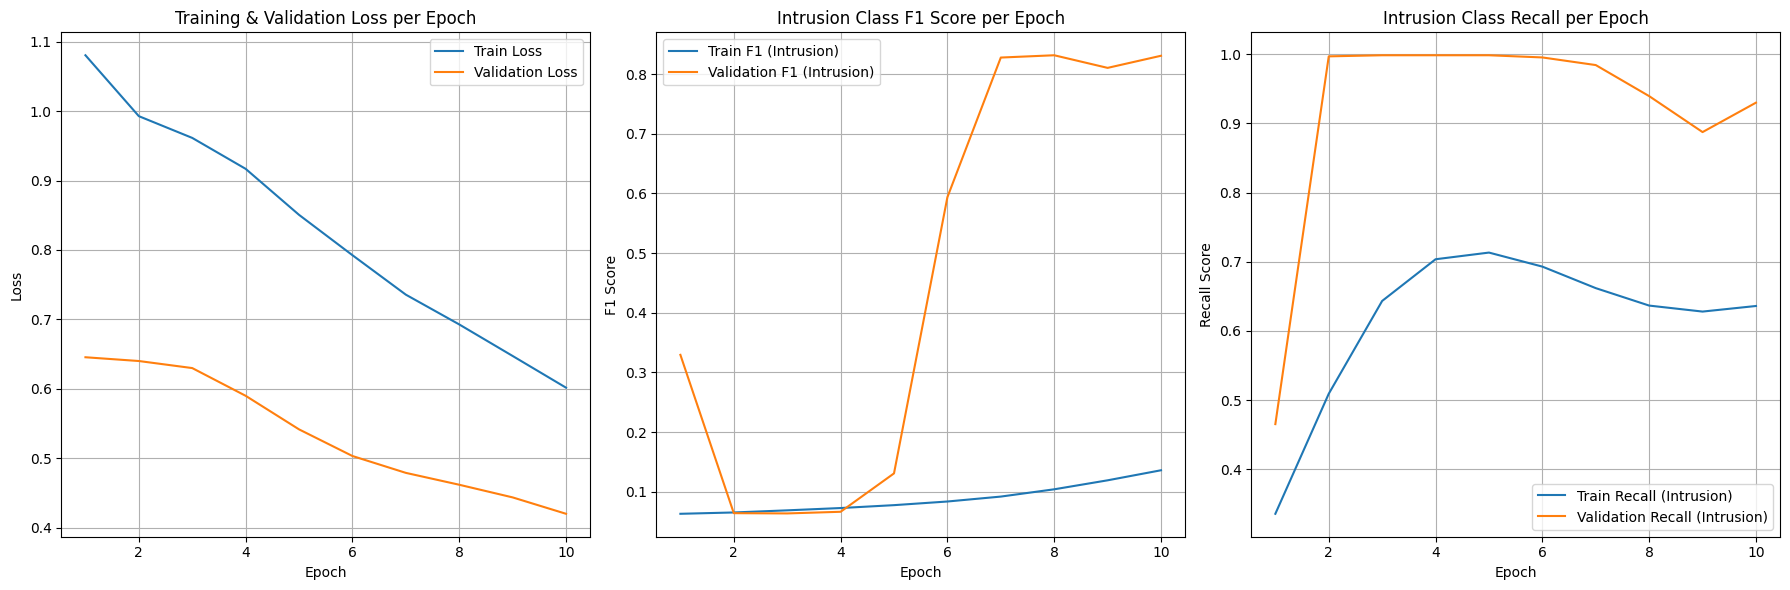


Final Results Summary (Last Epoch of Training):
Last Epoch: 10
  Train Loss: 0.6016 | Val Loss: 0.4200
  Train Acc: 0.7437 | Val Acc: 0.9880
  Train F1 (Intrusion): 0.1361 | Val F1 (Intrusion): 0.8308
  Train Recall (Intrusion): 0.6361 | Val Recall (Intrusion): 0.9299

Test Metrics (After Threshold Adjustment):
  Optimal Threshold Used: 0.4724
  Test Accuracy: 0.9883
  Test F1 (Intrusion): 0.8405
  Test Recall (Intrusion): 0.9740
  Test Precision (Intrusion): 0.7392

Project Execution Completed Successfully!

Block 13 execution finished.
--------------------------------------------------


In [ ]:
# Block 13: Final Summary / Plotting Metrics 
print("Block 13: Final Summary and Plotting Metrics...")

# --- Plot training and validation loss ---
plt.figure(figsize=(18, 6)) # Wider figure

plt.subplot(1, 3, 1) # Adjust subplot grid
plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot F1 score (or accuracy) ---
plt.subplot(1, 3, 2) # Adjust subplot grid
plt.plot(history['epoch'], history['train_f1_intru'], label='Train F1 (Intrusion)')
plt.plot(history['epoch'], history['val_f1_intru'], label='Validation F1 (Intrusion)')
plt.title('Intrusion Class F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# --- Plot Recall (or accuracy) ---
plt.subplot(1, 3, 3) # Adjust subplot grid
plt.plot(history['epoch'], history['train_recall_intru'], label='Train Recall (Intrusion)')
plt.plot(history['epoch'], history['val_recall_intru'], label='Validation Recall (Intrusion)')
plt.title('Intrusion Class Recall per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

print("\nFinal Results Summary (Last Epoch of Training):")
if history['epoch']: # Check if training actually ran
    print(f"Last Epoch: {history['epoch'][-1]}")
    print(f"  Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")
    print(f"  Train F1 (Intrusion): {history['train_f1_intru'][-1]:.4f} | Val F1 (Intrusion): {history['val_f1_intru'][-1]:.4f}")
    print(f"  Train Recall (Intrusion): {history['train_recall_intru'][-1]:.4f} | Val Recall (Intrusion): {history['val_recall_intru'][-1]:.4f}")
else:
    print("Training history is empty.")

# Use the metrics calculated in Block 12 which incorporate the threshold adjustment
print("\nTest Metrics (After Threshold Adjustment):")
print(f"  Optimal Threshold Used: {best_threshold:.4f}")
print(f"  Test Accuracy: {test_metrics_final.get('accuracy', 'N/A'):.4f}")
print(f"  Test F1 (Intrusion): {test_metrics_final.get('f1_intru', 'N/A'):.4f}")
print(f"  Test Recall (Intrusion): {test_metrics_final.get('recall_intru', 'N/A'):.4f}")
print(f"  Test Precision (Intrusion): {test_metrics_final.get('precision_intru', 'N/A'):.4f}")


print("\n===============================")
print("Project Execution Completed Successfully!")
print("===============================")
print("\nBlock 13 execution finished.")
print("-" * 50)